# Training an ANN to represent the gravity acceleration of Bennu 

In this notebook we use the trajectory of OSIRIS-Rex and of the pebbles to reverse the gravity field of Bennu

To run this notebook (and the others) create a conda environment using the following commands:
```
 conda create -n geodesyann python=3.8 ipython scikit-learn numpy h5py matplotlib jupyter
 conda activate geodesyann
 conda install -c pytorch pytorch
 conda install -c open3d-admin open3d
 pip install sobol_seq
 pip install tetgen
 conda install pyvista pyvistaqt
```

To use CUDA, you will need to run
```
 conda install pytorch torchvision cudatoolkit=10.2 -c pytorch
```


In [1]:
# core stuff
import gravann
import numpy as np
import pickle as pk
import os
from collections import deque

# pytorch
from torch import nn
import torch

# plotting stuff
import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d
%matplotlib notebook

# Ensure that changes in imported module (gravann most importantly) are autoreloaded
%load_ext autoreload
%autoreload 2

# If possible enable CUDA
gravann.enableCUDA()
gravann.fixRandomSeeds()
device = os.environ["TORCH_DEVICE"]
print("Will use device ",device) 


Available devices  1
__pyTorch VERSION: 1.6.0
__CUDNN VERSION: 7605
__Number CUDA Devices: 1
Active CUDA Device: GPU 0
Setting default tensor type to Float32
Will use device  cuda:0


# Loading and visualizing the ground truth asteroid (a point cloud)

In [2]:
with open("mascons/Bennu_nu.pk", "rb") as file:
    mascon_points, mascon_masses, mascon_name = pk.load(file)
    
mascon_points = torch.tensor(mascon_points)
mascon_masses = torch.tensor(mascon_masses)

print("Name: ", mascon_name)
print("Number of points: ", len(mascon_points))
print("Total mass: ", sum(mascon_masses))

print("Maximal minimal distance:",gravann.max_min_distance(mascon_points))

Name:  Bennu non-uniform
Number of points:  37799
Total mass:  tensor(1.0000, dtype=torch.float64)
Maximal minimal distance: 0.13160134851932526


<IPython.core.display.Javascript object>


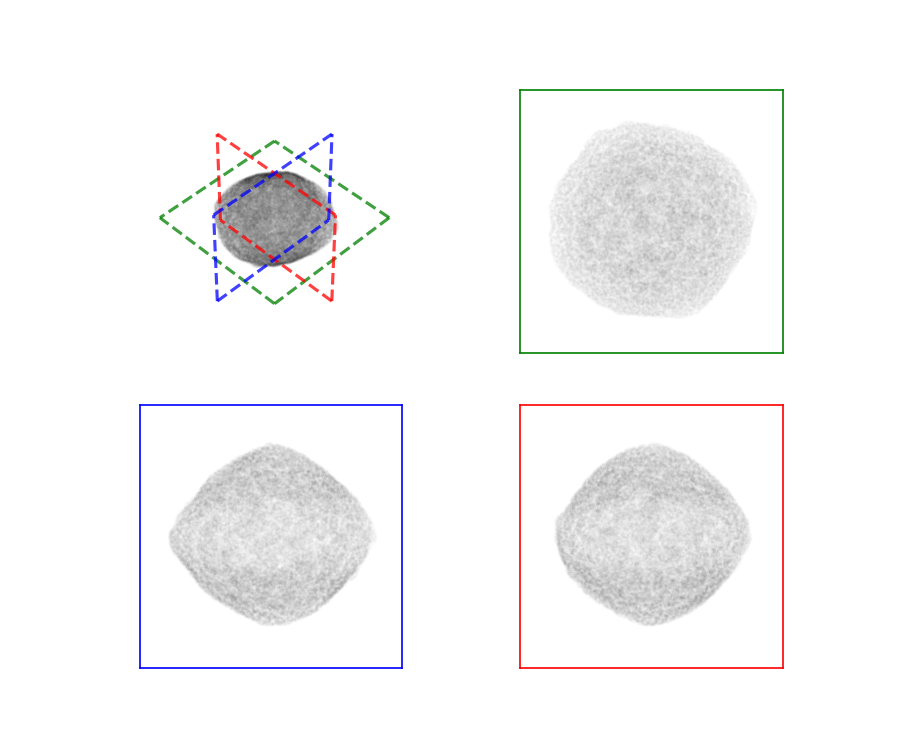

In [3]:
gravann.plot_mascon(mascon_points, mascon_masses)

In [5]:
## Loading the trajectory data, created on a different notebook from SPICE kernels

In [24]:
with open("osirisrex/pickled_bennu_900_cleaned.pk", "rb") as file:
    data_points, data_labels = pk.load(file)
data_points=torch.tensor(data_points)
data_labels=torch.tensor(data_labels)

In [25]:
with open("osirisrex/bennu_pebbles_filtered.pk", "rb") as file:
    _,_,data_points_p, data_labels_p = pk.load(file)
data_points_p=torch.tensor(data_points_p)
data_labels_p=torch.tensor(data_labels_p)

# Representing an asteroid via a neural network


## 1 - Instantiating the network
The networks inputs are the cartesian coordinates of a point in the unit cube, encoded via some transformation

In [17]:
# Encoding choosen
encoding = gravann.directional_encoding()
model = gravann.init_network(encoding, n_neurons=100, model_type="default")

# When a new network is created we init empty training logs
loss_log = []
weighted_average_log = []
running_loss_log = []
n_inferences = []
# .. and we init some loss trend indicators
weighted_average = deque([], maxlen=20)

In [18]:
# IF YOU NOW WANT TO LOAD THE ALREADY TRAINED NETWORK UNCOMMENT HERE.
## It is important that the network architecture is compatible, otherwise this will fail
#model.load_state_dict(torch.load("FILENAME"))

## Visualizing an asteroid represented by the network
The network output is the density in the unit cube. It is, essentially, a three dimensional function we plot via rejection sampling. 

Sampling points...: 4096it [00:00, 4346.93it/s]                                                                        


<IPython.core.display.Javascript object>


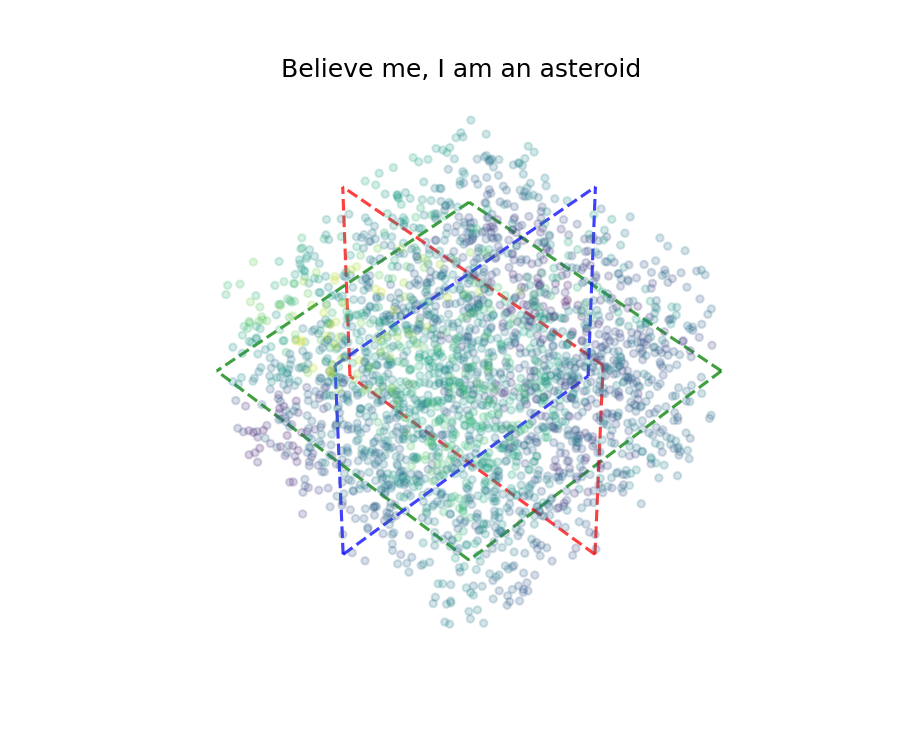

Text(0.5, 0.92, 'Believe me, I am an asteroid')

In [19]:
gravann.plot_model_rejection(model, encoding, views_2d=False, N=2500, progressbar=True, c=10)
plt.title("Believe me, I am an asteroid")

# Training The ANN to match the ground truth potential

Let it run up to when its < 1e-3 to actually see something that resembles the original asteroid. When stuck increase the number of monte carlo samples or play around the learning rate.

In [22]:
# EXPERIMENTAL SETUP ------------------------------------------------------------------------------------
# Here we set some hyperparameters
N_mc_points = 30000
batch_size = 100

# Here we set the loss
#loss_fn = gravann.mse_loss
loss_fn = gravann.normalized_L1_loss

# Here we set the choosen Integration method
#mc_method = gravann.ACC_ld
mc_method = gravann.ACC_trap

# Here we set the optimizer
learning_rate = 1e-4
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer,factor = 0.5, patience = 5000, min_lr = 5e-6,verbose=True)
# optimizer = torch.optim.SGD(model.parameters(), lr=0.1, momentum=0.9,nesterov=True)
# scheduler = torch.optim.lr_scheduler.CyclicLR(optimizer, base_lr=0.0005, max_lr=0.5, step_size_up=250, mode="exp_range", gamma = .997)

In [38]:
# This cell can be stopped and started again without loosing memory of the training nor its indicators
torch.cuda.empty_cache()
plt.close('all')
# The main training loop
for i in range(5000):
    # Each ten epochs we resample the target points
    if (i % 10 == 0):
        idxs = np.random.choice(np.arange(len(data_points_p)), batch_size, replace=False)
        target_points = data_points_p[idxs]
        labels = data_labels_p[idxs]
    
    # Compute the loss (use N=3000 to start with, then, eventually, beef it up to 200000)
    predicted = mc_method(target_points, model, encoding, N=N_mc_points)
    c = torch.sum(predicted*labels)/torch.sum(predicted*predicted)
    if loss_fn == gravann.contrastive_loss or loss_fn == gravann.normalized_relative_component_loss:
       loss = loss_fn(predicted, labels)
    else:
       loss = loss_fn(predicted.view(-1), labels.view(-1))
    # Update the loss trend indicators
    weighted_average.append(loss.item())
    # Update the logs
    weighted_average_log.append(np.mean(weighted_average))
    loss_log.append(loss.item())
    n_inferences.append((N_mc_points*batch_size) // 1000)
    # Print every i iterations
    if i % 25 == 0:
        wa_out = np.mean(weighted_average)
        print(f"It={i}\t loss={loss.item():.3e}\t  weighted_average={wa_out:.3e}\t  c={c:.3e}")
    # Before the backward pass, use the optimizer object to zero all of the
    # gradients for the variables it will update (which are the learnable
    # weights of the model). This is because by default, gradients are
    # accumulated in buffers( i.e, not overwritten) whenever .backward()
    # is called. Checkout docs of torch.autograd.backward for more details.
    optimizer.zero_grad()

    # Backward pass: compute gradient of the loss with respect to model
    # parameters
    loss.backward()

    # Calling the step function on an Optimizer makes an update to its
    # parameters
    optimizer.step()
    
    # Perform a step in LR scheduler to update LR
    scheduler.step(loss.item())

It=0	 loss=4.040e-03	  weighted_average=3.740e-03	  c=3.893e+00
It=25	 loss=4.765e-03	  weighted_average=4.063e-03	  c=3.551e+00
It=50	 loss=4.188e-03	  weighted_average=5.288e-03	  c=3.885e+00
It=75	 loss=3.580e-03	  weighted_average=3.827e-03	  c=3.556e+00
It=100	 loss=6.684e-03	  weighted_average=7.265e-03	  c=5.791e+00
It=125	 loss=4.228e-03	  weighted_average=5.399e-03	  c=5.623e+00
It=150	 loss=4.284e-03	  weighted_average=5.006e-03	  c=6.836e+00
It=175	 loss=4.281e-03	  weighted_average=4.204e-03	  c=5.676e+00
It=200	 loss=4.011e-03	  weighted_average=3.960e-03	  c=4.362e+00
It=225	 loss=4.316e-03	  weighted_average=4.060e-03	  c=3.737e+00
It=250	 loss=3.743e-03	  weighted_average=3.916e-03	  c=3.531e+00
It=275	 loss=3.923e-03	  weighted_average=3.682e-03	  c=3.352e+00
It=300	 loss=5.334e-03	  weighted_average=4.291e-03	  c=3.266e+00
It=325	 loss=4.292e-03	  weighted_average=4.283e-03	  c=3.335e+00
It=350	 loss=3.642e-03	  weighted_average=3.718e-03	  c=2.990e+00
It=375	 loss=5.

It=3075	 loss=4.110e-03	  weighted_average=4.086e-03	  c=2.762e+00
It=3100	 loss=3.841e-03	  weighted_average=4.553e-03	  c=2.725e+00
It=3125	 loss=3.775e-03	  weighted_average=3.678e-03	  c=2.631e+00
It=3150	 loss=3.701e-03	  weighted_average=3.753e-03	  c=2.693e+00
It=3175	 loss=3.376e-03	  weighted_average=3.685e-03	  c=2.742e+00
It=3200	 loss=6.745e-03	  weighted_average=4.038e-03	  c=2.733e+00
It=3225	 loss=3.735e-03	  weighted_average=4.201e-03	  c=3.572e+00
It=3250	 loss=3.718e-03	  weighted_average=3.821e-03	  c=3.128e+00
It=3275	 loss=3.796e-03	  weighted_average=3.626e-03	  c=2.805e+00


KeyboardInterrupt: 

Sampling points...: 1574it [00:01, 1542.93it/s]                                                                        


<IPython.core.display.Javascript object>


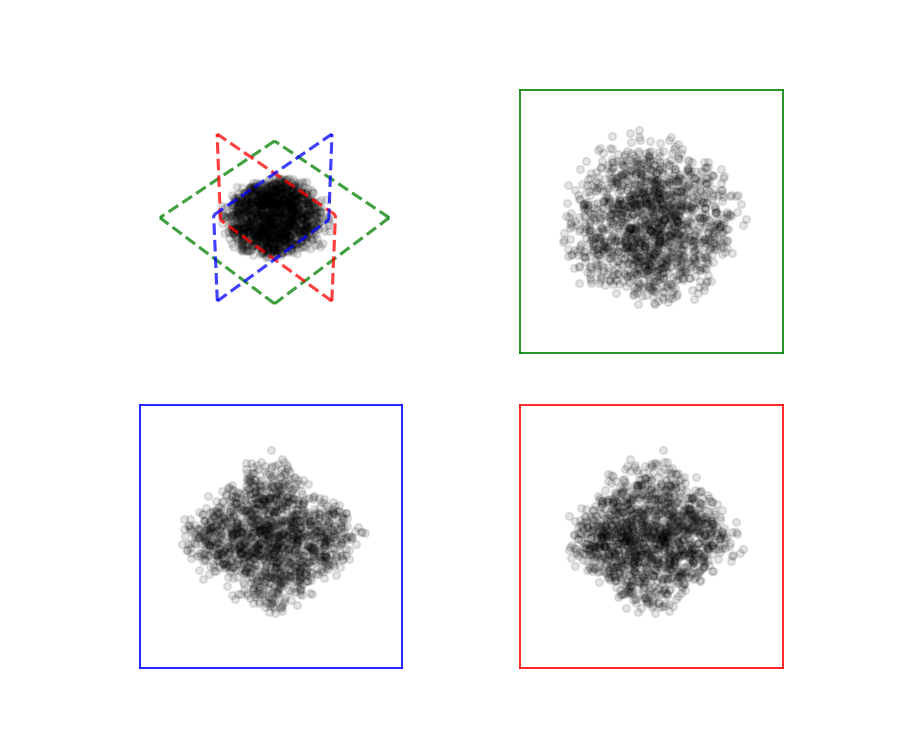

In [39]:
# Rejection plot
gravann.plot_model_rejection(model, encoding, views_2d=True, bw=True, N=1500, alpha=0.1, s=50, c=c, crop_p=0.1, progressbar=True)

<IPython.core.display.Javascript object>


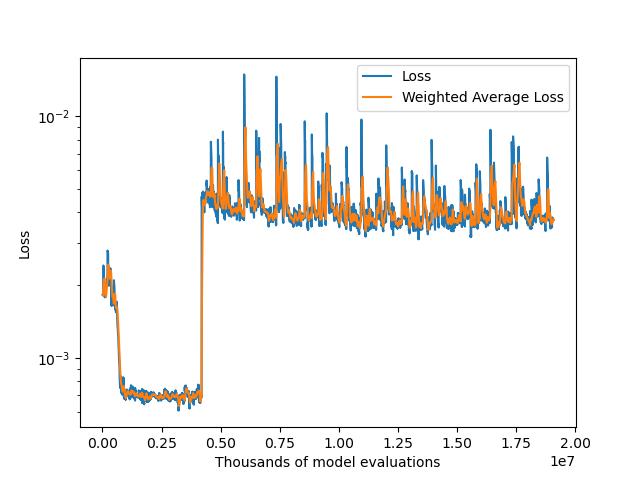

In [40]:
# Plot the loss history
plt.figure()
abscissa = np.cumsum(n_inferences)
plt.semilogy(abscissa, loss_log)
plt.semilogy(abscissa, weighted_average_log)
plt.xlabel("Thousands of model evaluations")
plt.ylabel("Loss")
plt.legend(["Loss","Weighted Average Loss"])

Sampling points...: 2605it [00:01, 1708.90it/s]                                                                        


<IPython.core.display.Javascript object>


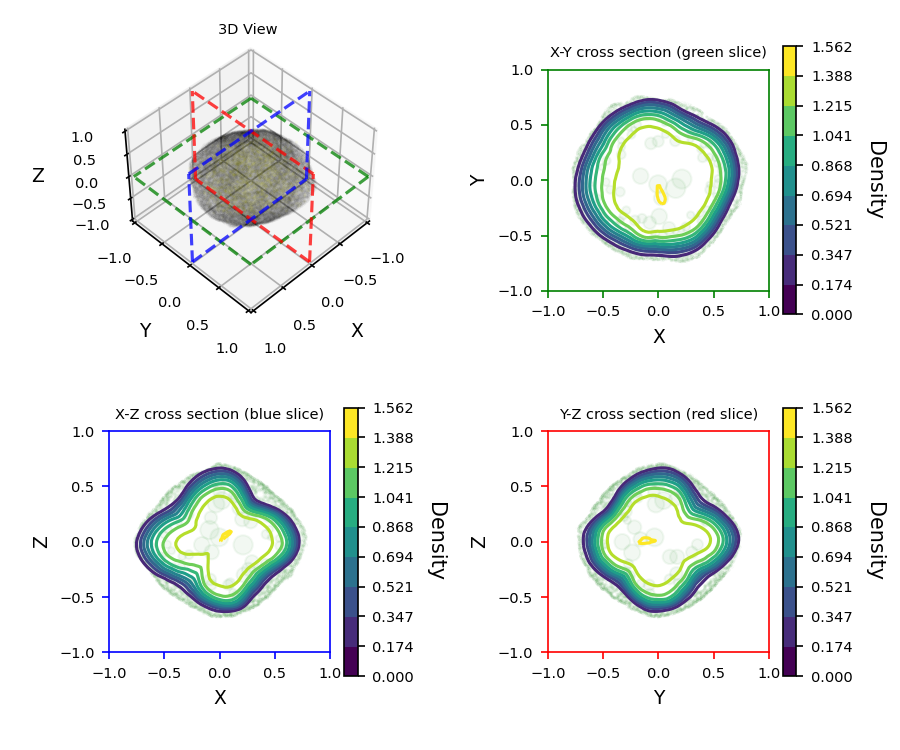

<Axes3DSubplot:title={'center':'3D View'}, xlabel='X', ylabel='Y'>

In [41]:
# Rejection plot overlayed with the mascon
gravann.plot_model_vs_mascon_contours(model, encoding, mascon_points, mascon_masses,c=c, progressbar = True, N=2500, heatmap=False)

In [ ]:
# Generating a mesh out of the model
gravann.plot_model_mesh(model,encoding,rho_threshold=c.cpu().detach().numpy()*1e-2) 

In [ ]:
# Compute c 
#target_points = targets_point_sampler()
#labels = gravann.ACC_L(target_points, mascon_points, mascon_masses)
#predicted = mc_method(target_points, model, encoding, N=N_mc_points)
#c = torch.sum(predicted*labels)/torch.sum(predicted*predicted)

In [ ]:
# Computes the Validation table
gravann.validation(model, encoding, mascon_points, mascon_masses, use_acc=True, asteroid_pk_path="3dmeshes/Bennu_lp.pk", N=5000, N_integration=500000, batch_size=32, progressbar=True)

In [ ]:
# Compute the acceleration plot
gravann.plot_model_mascon_acceleration("3dmeshes/Bennu.pk", model, encoding, mascon_points, mascon_masses, plane="XY", c=c, N=5000, logscale=False)

In [ ]:
# Compute the acceleration plot
gravann.plot_model_mascon_acceleration("3dmeshes/Bennu.pk", model, encoding, mascon_points, mascon_masses, plane="XZ", c=c, N=5000, logscale=False)

In [ ]:
gravann.plot_model_mascon_acceleration("3dmeshes/Bennu.pk", model, encoding, mascon_points, mascon_masses, plane="YZ", c=c, N=5000, logscale=False)

#### Saving the model

In [ ]:
# Uncomment to save to models/cluster_xxxx
#torch.save(model.state_dict(), "models/siren_acc_bennu.mdl")